In [1]:
import numpy as np
import os

DATA_PATH = 'Anuran_Calls_(MFCCs)'

In [2]:
import pandas as pd

def load_csv(path = DATA_PATH):
    csv_path = os.path.join(path, 'Frogs_MFCCs.csv')
    return pd.read_csv(csv_path)

In [3]:
df = load_csv()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7195 entries, 0 to 7194
Data columns (total 26 columns):
MFCCs_ 1    7195 non-null float64
MFCCs_ 2    7195 non-null float64
MFCCs_ 3    7195 non-null float64
MFCCs_ 4    7195 non-null float64
MFCCs_ 5    7195 non-null float64
MFCCs_ 6    7195 non-null float64
MFCCs_ 7    7195 non-null float64
MFCCs_ 8    7195 non-null float64
MFCCs_ 9    7195 non-null float64
MFCCs_10    7195 non-null float64
MFCCs_11    7195 non-null float64
MFCCs_12    7195 non-null float64
MFCCs_13    7195 non-null float64
MFCCs_14    7195 non-null float64
MFCCs_15    7195 non-null float64
MFCCs_16    7195 non-null float64
MFCCs_17    7195 non-null float64
MFCCs_18    7195 non-null float64
MFCCs_19    7195 non-null float64
MFCCs_20    7195 non-null float64
MFCCs_21    7195 non-null float64
MFCCs_22    7195 non-null float64
Family      7195 non-null object
Genus       7195 non-null object
Species     7195 non-null object
RecordID    7195 non-null int64
dtypes: float6

In [5]:
# Number of instances by class
df.loc[:,'Family'].value_counts()

Leptodactylidae    4420
Hylidae            2165
Dendrobatidae       542
Bufonidae            68
Name: Family, dtype: int64

In [6]:
df.loc[:,'Genus'].value_counts()

Adenomera        4150
Hypsiboas        1593
Ameerega          542
Dendropsophus     310
Leptodactylus     270
Scinax            148
Osteocephalus     114
Rhinella           68
Name: Genus, dtype: int64

In [7]:
df.loc[:,'Species'].value_counts()

AdenomeraHylaedactylus    3478
HypsiboasCordobae         1121
AdenomeraAndre             672
Ameeregatrivittata         542
HypsiboasCinerascens       472
HylaMinuta                 310
LeptodactylusFuscus        270
ScinaxRuber                148
OsteocephalusOophagus      114
Rhinellagranulosa           68
Name: Species, dtype: int64

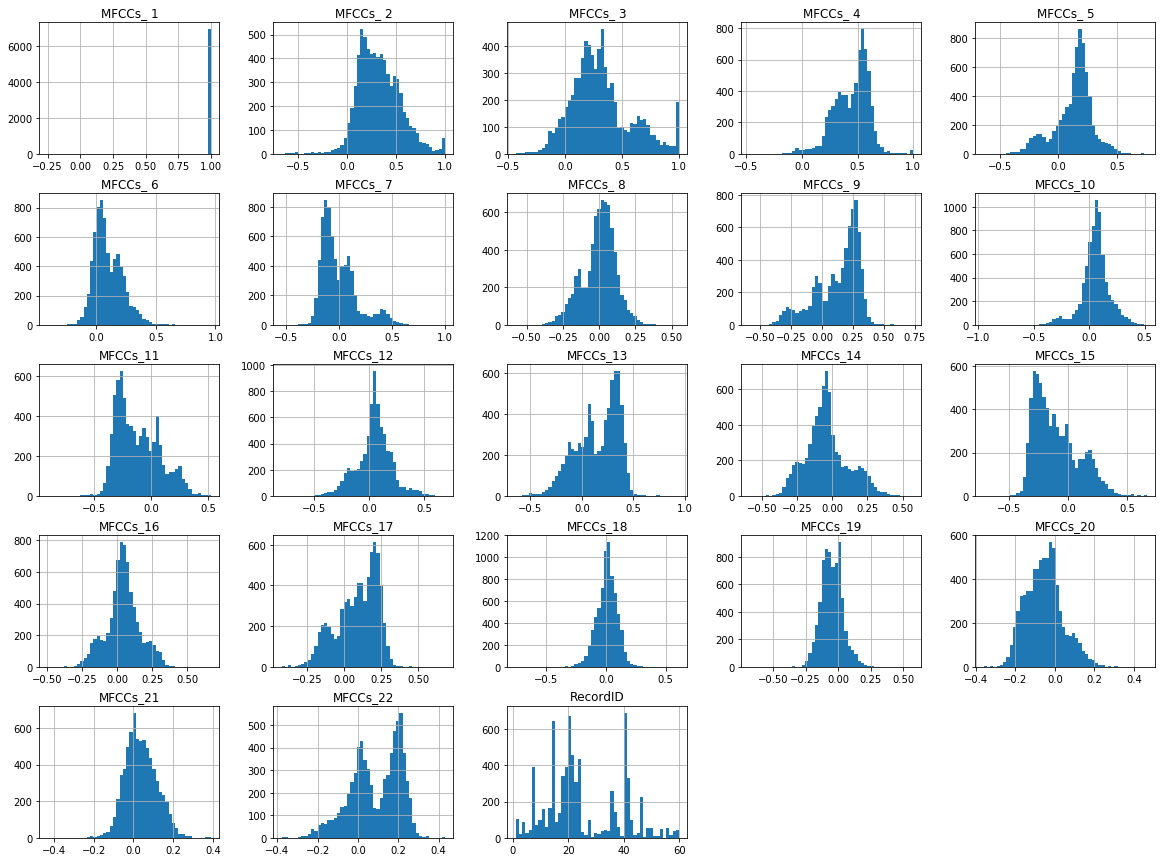

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
# Right now only choosing species
X, Y = df.loc[:,'MFCCs_ 1':'MFCCs_22'], df.loc[:, 'Species']

In [9]:
from imblearn.under_sampling import RandomUnderSampler

dict = {
    'AdenomeraHylaedactylus': 1121
}

rus = RandomUnderSampler(ratio=dict)
X_resampled, Y_resampled = rus.fit_sample(X, Y)

print(str(X_resampled.size))
print(str(Y_resampled.size))

print(str(X.size))
print(str(Y.size))

print(pd.value_counts(Y_resampled))

106436
4838
158290
7195
AdenomeraHylaedactylus    1121
HypsiboasCordobae         1121
AdenomeraAndre             672
Ameeregatrivittata         542
HypsiboasCinerascens       472
HylaMinuta                 310
LeptodactylusFuscus        270
ScinaxRuber                148
OsteocephalusOophagus      114
Rhinellagranulosa           68
dtype: int64


In [10]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def createOneHotEncoded(arg):
    
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(arg)
    
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded

In [44]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

def createModel():
    model = Sequential()

    model.add(Dense(units=32, activation='relu', input_dim=22))
    model.add(Dense(units=64, activation='relu'))
    #model.add(Dense(units=32, activation='relu'))
    
    model.add(Dense(units=10, activation='softmax')) #10 species
    
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
    
    return model

In [41]:
from sklearn.metrics import classification_report

def testModel(model, x_train, y_train, x_val, y_val):
    history = model.fit(x_train, y_train, batch_size=32, epochs=50, verbose=0)
    
    pred = model.predict(x_val, batch_size=32, verbose=1)
    predicted = np.argmax(pred, axis=1)
    
    report = classification_report(np.argmax(y_val, axis=1), predicted)
    print(report)
    
    return history

972/972 [==============================] - 1s 1ms/step
             precision    recall  f1-score   support

          0       0.91      0.94      0.92       135
          1       0.99      0.99      0.99       225
          2       0.84      0.99      0.91       109
          3       0.88      0.68      0.76        62
          4       0.87      0.97      0.92        95
          5       0.97      1.00      0.99       225
          6       0.98      0.91      0.94        54
          7       0.76      0.57      0.65        23
          8       0.80      0.29      0.42        14
          9       1.00      0.70      0.82        30

avg / total       0.93      0.93      0.93       972

970/970 [==============================] - 1s 1ms/step
             precision    recall  f1-score   support

          0       0.91      0.96      0.93       135
          1       0.96      1.00      0.98       224
          2       0.84      0.97      0.90       109
          3       0.87      0.65      

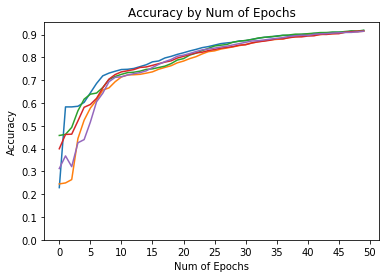

In [47]:
from sklearn.model_selection import StratifiedKFold

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=5, shuffle=True)

result = []

for index, (train_indices, val_indices) in enumerate(skf.split(X_resampled, Y_resampled)):
    
    # Generate batches from indices
    xtrain, xval = X_resampled[train_indices], X_resampled[val_indices]
    ytrain, yval = createOneHotEncoded(Y_resampled[train_indices]), createOneHotEncoded(Y_resampled[val_indices])
    
    # Clear model, and create it
    model = None
    model = createModel()
    
    history = testModel(model, xtrain, ytrain, xval, yval)
    
    result.append(history)
    

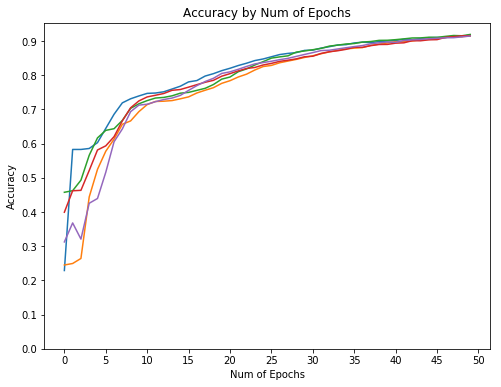

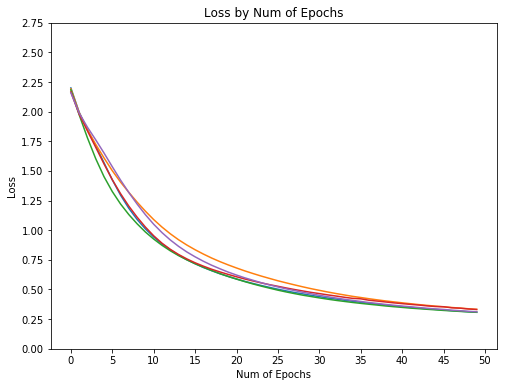

In [49]:
plotAccuracy(result)
plotLoss(result)


In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

def plotAccuracy(results):
    plt.figure(0)
    
    for val in results:
        plt.plot(val.history['acc'])
        
    plt.xticks(np.arange(0, 55, 5.0))
    plt.yticks(np.arange(0, 1.0, 0.1))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy by Num of Epochs")

    plt.show()
    
def plotLoss(results):
    plt.figure(1)
    
    for val in results:
        plt.plot(val.history['loss'])
        
    plt.xticks(np.arange(0, 55, 5.0))
    plt.yticks(np.arange(0, 2.8, 0.25))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title("Loss by Num of Epochs")

    plt.show()
    